### Question data

In [1]:
# Load metadata.jsonl
import json
# Load the metadata.jsonl file
with open('metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

In [2]:
# randomly select 3 samples
# {"task_id": "c61d22de-5f6c-4958-a7f6-5e9707bd3466", "Question": "A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?", "Level": 2, "Final answer": "egalitarian", "file_name": "", "Annotator Metadata": {"Steps": "1. Go to arxiv.org and navigate to the Advanced Search page.\n2. Enter \"AI regulation\" in the search box and select \"All fields\" from the dropdown.\n3. Enter 2022-06-01 and 2022-07-01 into the date inputs, select \"Submission date (original)\", and submit the search.\n4. Go through the search results to find the article that has a figure with three axes and labels on each end of the axes, titled \"Fairness in Agreement With European Values: An Interdisciplinary Perspective on AI Regulation\".\n5. Note the six words used as labels: deontological, egalitarian, localized, standardized, utilitarian, and consequential.\n6. Go back to arxiv.org\n7. Find \"Physics and Society\" and go to the page for the \"Physics and Society\" category.\n8. Note that the tag for this category is \"physics.soc-ph\".\n9. Go to the Advanced Search page.\n10. Enter \"physics.soc-ph\" in the search box and select \"All fields\" from the dropdown.\n11. Enter 2016-08-11 and 2016-08-12 into the date inputs, select \"Submission date (original)\", and submit the search.\n12. Search for instances of the six words in the results to find the paper titled \"Phase transition from egalitarian to hierarchical societies driven by competition between cognitive and social constraints\", indicating that \"egalitarian\" is the correct answer.", "Number of steps": "12", "How long did this take?": "8 minutes", "Tools": "1. Web browser\n2. Image recognition tools (to identify and parse a figure with three axes)", "Number of tools": "2"}}

import random
# random.seed(42)
random_samples = random.sample(json_QA, 1)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: e0c10771-d627-4fd7-9694-05348e54ee36
Question: Take the gender split from the 2011 Bulgarian census about those who have completed tertiary education. Subtract the smaller number from the larger number, then return the difference in thousands of women. So if there were 30.1 thousand more men, you'd give "30.1"
Level: 2
Final Answer: 234.9
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Find the report put out by the Bulgarian on the 2011 census by searching.
  │      ├── 2. Find the requested data under the Educational Structure Section of the Report.
  │      ├── 3. 791.8 thousand women - 556.9 thousand men = 234.9 thousand women
  ├── Number of steps: 3
  ├── How long did this take?: 10 minutes
  ├── Tools:
  │      ├── 1. search engine
  │      ├── 2. pdf reader/extracter
  └── Number of tools: 2


In [4]:
### build a vector database based on the metadata.jsonl
# https://python.langchain.com/docs/integrations/vectorstores/supabase/
import os
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore
from supabase.client import Client, create_client


load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

In [5]:
# wrap the metadata.jsonl's questions and answers into a list of document
from langchain.schema import Document
docs = []
for sample in json_QA:
    content = f"Question : {sample['Question']}\n\nFinal answer : {sample['Final answer']}"
    doc = {
        "content" : content,
        "metadata" : { 
            "source" : sample['task_id']
        },
        "embedding" : embeddings.embed_query(content),
    }
    docs.append(doc)

# upload the documents to the vector database
try:
    response = (
        supabase.table("documents")
        .insert(docs)
        .execute()
    )
except Exception as exception:
    print("Error inserting data into Supabase:", exception)

# ALTERNATIVE : Save the documents (a list of dict) into a csv file, and manually upload it to Supabase
# import pandas as pd
# df = pd.DataFrame(docs)
# df.to_csv('supabase_docs.csv', index=False)

In [6]:
# add items to vector database
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding= embeddings,
    table_name="documents",
    query_name="match_documents_langchain",
)
retriever = vector_store.as_retriever()

In [7]:
query = "On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?"
# matched_docs = vector_store.similarity_search(query, 2)
docs = retriever.invoke(query)
docs[0]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


APIError: {'message': 'Could not find the function public.match_documents_langchain(query_embedding) in the schema cache', 'code': 'PGRST202', 'hint': None, 'details': 'Searched for the function public.match_documents_langchain with parameter query_embedding or with a single unnamed json/jsonb parameter, but no matches were found in the schema cache.'}

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTP

In [8]:
# list of the tools used in all the samples
from collections import Counter, OrderedDict

tools = []
for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        tool = tool[2:].strip().lower()
        if tool.startswith("("):
            tool = tool[11:].strip()
        tools.append(tool)
tools_counter = OrderedDict(Counter(tools))
print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))
for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

#### Graph

In [9]:
system_prompt = """
You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
==========================
Here is a few examples showing you how to answer the question step by step.
"""
for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"
system_prompt += "\n==========================\n"
system_prompt += "Now, please answer the following question step by step.\n"

# save the system_prompt to a file
with open('system_prompt.txt', 'w') as f:
    f.write(system_prompt)

In [10]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
Here is a few examples showing you how to answer the question step by step.

Question 1: Take the gender split from the 2011 Bulgarian census about those who have completed tertiary education. Subtract the smaller number from the larger number, then return the difference in thousands of women. So if there were 30.1 thousand more men, you'd give "30.1"
Steps:
1. Find the report put out by the Bulgarian on the 2011 census by searching.
2. Find the requested data under the Educational Structure Section of the Report.
3. 791.8 thousand women - 556.9 thousand men = 234.9 thousand women
Tools:
1. search engine
2. pdf reader/extracter
Final Answer: 234.9

Now, please answer the following question st

In [11]:
import dotenv
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.document_loaders import ArxivLoader
from langchain_community.vectorstores import SupabaseVectorStore
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from supabase.client import Client, create_client

# Define the retriever from supabase
load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding= embeddings,
    table_name="documents",
    query_name="match_documents_langchain",
)

question_retrieve_tool = create_retriever_tool(
    vector_store.as_retriever(),
    "Question Retriever",
    "Find similar questions in the vector database for the given question.",
)

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers.
    
    Args:
        a: first int
        b: second int
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

@tool
def modulus(a: int, b: int) -> int:
    """Get the modulus of two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a % b

@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for a query and return maximum 2 results.
    
    Args:
        query: The search query."""
    search_docs = WikipediaLoader(query=query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"wiki_results": formatted_search_docs}

@tool
def web_search(query: str) -> str:
    """Search Tavily for a query and return maximum 3 results.
    
    Args:
        query: The search query."""
    search_docs = TavilySearchResults(max_results=3).invoke(query=query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"web_results": formatted_search_docs}

@tool
def arvix_search(query: str) -> str:
    """Search Arxiv for a query and return maximum 3 result.
    
    Args:
        query: The search query."""
    search_docs = ArxivLoader(query=query, load_max_docs=3).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
            for doc in search_docs
        ])
    return {"arvix_results": formatted_search_docs}

@tool
def similar_question_search(question: str) -> str:
    """Search the vector database for similar questions and return the first results.
    
    Args:
        question: the question human provided."""
    matched_docs = vector_store.similarity_search(query, 3)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
            for doc in matched_docs
        ])
    return {"similar_questions": formatted_search_docs}

tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arvix_search
    ]

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [12]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()


# System message
sys_msg = SystemMessage(content=system_prompt)

# Node
def assistant(state: MessagesState):
    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
graph = builder.compile()


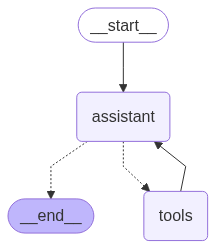

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
question = "A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?"
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages})

In [18]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?
================================== Ai Message ==================================

Here's how we can approach this problem:

1. **Find the AI regulation paper:** Use the `arvix_search` tool to find the paper submitted in June 2022 about AI regulation.
2. **Extract the axis labels:**  Once we find the paper, we need to look at the content and identify the three axes and their labels.
3. **Find the Physics and Society article:** Use the `arvix_search` tool to find the article submitted on August 11, 2016, to the Physics and Society section.
4. **Check for the society type:** Read the Physics and Society article and 